# Battle of the Neighborhoods - House Buying Search

### Table of Contents:

1. [Introduction/Business Understanding](#intro)
2. [Analytic Approach](#approach)
3. [Data Requirements](#requirements)
4. [Data Preparation/Pre-processing](#prep)
5. [Analysis](#anaylysis)
6. [Conclusion](#conclusion)

## 1. Introduction/Business Understanding 

### 1.1 Background

As an engineer working 5+ years in the automotive industry since graduating from post secondary school, I am now looking to take the next step in my life which is to purchase a house.  At first when I started to look into purchasing a house I was only focused on the house itself, but I soon realized that if I wanted to live there long term I also need to look at the surrounding amenities as I did not want a *commuter* house.  

When moving into an area it is important that the house meets your needs while the neighborhood also suits your lifestyle.  As a young adult the following list is what I would be looking for in my search for a house:

1. Affordable neighborhood
2. Fitness ameneties in the surrounding area
3. Restaurants and coffee shops within walking distance

### 1.2 Problem Description

Purchasing a house is a very big decision to make.  This decision has many obstacles as there are many unknowns which includes the following:

* What city to purchase the house in?
* What are the different neighborhoods in the city?
* Where is each neighborhood within the city?
* How do housing prices vary with location?
* What kind of popular venues are around each neighborhood?
* How many available house listings are their in each location?

With all of these unknowns it would take a significant amount of time to answer these questions by combing the internet.  Time is definitely a luxury in my current situation with the high number of hours I work every week so an efficient method to summarize findings would be ideal compared to spending hours on end combing the internet with findings being manually written down.  

For this project we will be comparing neighborhoods in the cities of Hamilton and Burlington to determine the ideal location for me to purchase a house.

### 1.3 Target Audience

This project will serve **young adults** to help make an informed decision on where to purchase a house in Hamilton and Burlington by providing an in-depth analysis of neighborhood housing costs, available housing listings, and surrounding venues.

## 2. Analytic Approach

In this project I will be taking analytic approaches:

**1. Exploratory Data Analysis (EDA)** - To discover details in the data that will contribute in providing useful insights to the reader and young adults.  
**2. Prescriptive Analytics** - To provide the reader and young adults information in regards to similarities and differences between neighborhoods and their surround venues.  K-Means Clustering will be used in this situation.

## 3. Data Requirements

Two cities will be analyzed in this project:
* Hamilton
* Burlington

The datasources used are listed below including how the datasets will be created from them:

**1.** [**List of Postal Codes L: Canada**](https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_L)**:** A dataset which includes information of neighborhoods for each city will be created by web scraping the table for L postal codes in Canada in Wikipedia.<br>

**2.** [**Avg Housing List Price**](https://www.zoocasa.com/ontario-cities)**:** A dataset which includes average housing list price by city and neighborhood will be created by web scraping several pages from Zoocasa and used for EDA. <br>

**3.** [**Foursquare API**](https://developer.foursquare.com/docs/places-api/)**:** This API will be utilized to gather venue information around the neighborhoods in each city which will be used for EDA and clustering.

First I will visualize the postal code dataset with a map to confirm the accuracy of the city data.  Once confirmed, I will narrow down the dataset to include Hamilton and Burlington neighborhoods only.  I will then use EDA to compare the average house pricing and number of available listings between neighborhoods in both cities.  Lastly I will cluster similar neighborhoods based on common surrounding venues.

# 4. Data Preparation/Pre-Processing

We will import the libraries we believe we need.  If we are missing anything the library will be imported at a later point.

In [1]:
import requests
import re
from bs4 import BeautifulSoup
import pandas as pd
!pip install geocoder
import geocoder
import numpy as np
import json

     |████████████████████████████████| 102kB 7.2MB/s ta 0:00:011


### 4.1 City and Neighborhood Dataset

We will create a dataset that includes the following information: postal codes, cities, neighborhoods, geographical coordinates.

To obtain the postal codes, cities, and neighborhoods we will scrape the Wikipedia page [**List of Postal Codes L: Canada**](https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_L) using BeautifulSoup.  

In [2]:
# Ensure headers is set with a valid browser.
headers = requests.utils.default_headers()
headers.update({ 'User-Agent': 'Chrome/6.0.472.63 Sfari/534.3a'})

# Using the url of the wikipedia page we use the 'requests' function to confirm we have a good connection with the web page (response 200 is expected result).
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_L"
req = requests.get(url, headers)
req

<Response [200]>

In [3]:
# Using BeautifulSoup we are able to parse the source data.
soup = BeautifulSoup(req.content, 'html.parser')

# Narrow down the source data to the target table so we can scrape the data in each cell.
table = soup.find('table')
rows = table.find_all('td')

# Empty dictionary is created as we will be filling it with the data from the web page table.
postal_codes_dict = {}

# Loop to go through each cell in the webpage where the data will be added to the empty dictionary. 
for row in rows:
    try:
        postal_code = row.b.text
        city_data = row.span.get_text()
        
        # If postal code does not have an assigned city/neighborhoods, ignore the cell.  Otherwise put the text in the cell into the dictionary
        if city_data == "Not assigned":
            city_data = []
        else:
            postal_codes_dict[postal_code] = {}

        # Split text in the cells into a list to allow us to segregate the city names and neighborhoods as they are all combined into one cell in the table for each postal code
        postal_codes_dict[postal_code]['city'] = city_data
        r = re.split("[/|(|)]",city_data)

        # Segregate city and neighborhood text within the list from the split text data above
        # If statement used to resolve issue of St. Catherines only showing up as only "St." for the city. 
        if r[0] == 'St':
            city_data = '.'.join([i for i in r[0:2] if len(i) > 1])
            neighborhood = ','.join([i for i in r[2:] if len(i) > 2])
        else:
            city_data = r[0]
            neighborhood = ','.join([i for i in r[1:] if len(i) > 2])

        # Insert segregated city and neighborhood names into the dictionary
        postal_codes_dict[postal_code]['city'] = city_data
        postal_codes_dict[postal_code]['neighborhood'] = neighborhood


    except:
        pass

In [4]:
# Create dataframe with data from postal_codes_dict dictionary
columns = ['PostalCode', 'City', 'Neighborhood']
postal_code_data = pd.DataFrame(columns = columns)

for index, postal_code in enumerate(postal_codes_dict):
    neighborhood = postal_codes_dict[postal_code]['neighborhood']
    city = postal_codes_dict[postal_code]['city']
    postal_code_data = postal_code_data.append({'PostalCode': postal_code,
                                                'City': city,
                                                'Neighborhood': neighborhood},
                                               ignore_index = True)

postal_code_data.head(10)

,PostalCode,City,Neighborhood
0,L1A,Port Hope,
1,L2A,Fort Erie,
2,L4A,Stouffville,
3,L5A,Mississauga,"Mississauga Valley , East Cooksville"
4,L6A,Vaughn,Maple
5,L7A,Brampton,West
6,L9A,Hamilton,"Crerar , Bruleville , Hill Park , Inch Park , ..."
7,L1B,Bowmanville,East
8,L3B,Welland,East
9,L4B,Richmond Hill,Southeast


In [5]:
# Obtain coordinates for each postal code, create an empty dictionary to put data into
lat_lng_dict ={}

for a, b in zip(postal_code_data['PostalCode'], postal_code_data['City']):
    postal_code = a
    city = b

# initialize variable to None
    lat_lng_coords = None

# loop until coordinates obtained, google gecode needs you to pay for it so using arcgis
    while(lat_lng_coords is None):
      g = geocoder.arcgis('{}, {}, Ontario'.format(postal_code, city))
      lat_lng_coords = g.latlng

    latitude = lat_lng_coords[0]
    longitude = lat_lng_coords[1]
    
    lat_lng_dict[postal_code] = {}
    lat_lng_dict[postal_code]['latitude'] = latitude
    lat_lng_dict[postal_code]['longitude'] = longitude
    lat_lng_columns = ['PostalCode', 'Latitude', 'Longitude']
    lat_lng_data = pd.DataFrame(columns = lat_lng_columns)

In [6]:
# Create dataframe with postal code coordinates obtained and merge with postal code dataframe created previously
for index, postal_code in enumerate(lat_lng_dict):
    latitude = lat_lng_dict[postal_code]['latitude']
    longitude = lat_lng_dict[postal_code]['longitude']
    lat_lng_data = lat_lng_data.append({'PostalCode': postal_code,
                                                'Latitude': latitude,
                                                'Longitude': longitude},
                                               ignore_index = True)

merged_data = postal_code_data.merge(lat_lng_data, on = 'PostalCode')
merged_data.head(10)

,PostalCode,City,Neighborhood,Latitude,Longitude
0,L1A,Port Hope,,43.991392,-78.371409
1,L2A,Fort Erie,,42.919585,-78.955114
2,L4A,Stouffville,,44.017718,-79.300813
3,L5A,Mississauga,"Mississauga Valley , East Cooksville",43.587200,-79.608871
4,L6A,Vaughn,Maple,43.876157,-79.510711
5,L7A,Brampton,West,43.692870,-79.837790
6,L9A,Hamilton,"Crerar , Bruleville , Hill Park , Inch Park , ...",43.226064,-79.870944
7,L1B,Bowmanville,East,43.913770,-78.688550
8,L3B,Welland,East,42.994102,-79.231450
9,L4B,Richmond Hill,Southeast,43.858737,-79.401515


### 4.2 Visualize City and Neighborhood Dataset

We will first confirm the accuracy of the postal code data and coordinates by visualizing the cities on a map.  Once confirmed we will narrow down the dataset to show Hamilton and Burlington neighborhoods in which we will visualize in another map.

To centralize the map confirming cities we will obtain and use Toronto coordinates.

In [7]:
# Import folium to be able to create maps
!pip install folium
import folium

     |████████████████████████████████| 102kB 7.0MB/s ta 0:00:011


In [8]:
# Obtaining Toronto coordinates
from geopy.geocoders import Nominatim
address = 'Toronto'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Ontario are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Ontario are 43.6534817, -79.3839347.


In [9]:
# Utilize city data only from dataset to visualize cities on a map
city_data = merged_data.groupby(['City'], as_index = False).mean()
city_data.head()

,City,Latitude,Longitude
0,Acton,43.613557,-80.034958
1,Ajax,43.867458,-79.027891
2,Alliston,44.155454,-79.890045
3,Aurora,43.995874,-79.446317
4,Barrie,44.377597,-79.670211


In [10]:
# Create map with city data for postal codes starting with L
map_ontario = folium.Map(location=[latitude, longitude], zoom_start=8)

for lat, lng, city in zip(city_data['Latitude'], city_data['Longitude'], city_data['City']):
    label = '*{}*'.format(city)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_ontario)  

map_ontario

Based on the map above the coordinates obtained for the City and Neighborhood dataset looks to be accurate.  We will continue using this data to map out the neighborhoods in Hamilton and Burlington for analysis.

Let's visualize the neighborhoods for Burlington followed by Hamilton.

In [11]:
# Narrow down dataset to only include Burlington data 
burlington_data = merged_data.loc[merged_data['City'] == 'Burlington']
burlington_data

,PostalCode,City,Neighborhood,Latitude,Longitude
66,L7L,Burlington,"Corporate, Elizabeth Gardens , Longmoor , Pine...",43.384449,-79.767496
75,L7M,Burlington,"Alton Village , Headon Forest , Millcroft , Pa...",43.417438,-79.857794
82,L7N,Burlington,"Dynes, Roseland",43.351052,-79.783412
91,L7P,Burlington,"Brant Hills , Tyandaga , Mountainside",43.372384,-79.879311
100,L7R,Burlington,"Downtown , Plains",43.353290,-79.804560
109,L7S,Burlington,Maple,43.317173,-79.810205
118,L7T,Burlington,"Aldershot Central , Aldershot South",43.313290,-79.855320


In [12]:
# Obtain coordinates to centralize map for Burlington
from geopy.geocoders import Nominatim
address = 'Burlington, ON'

geolocator = Nominatim(user_agent="burlington_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Burlington are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Burlington are 43.3248924, -79.7966835.


In [13]:
# Visualize Burlington neighborhoods
map_burlington = folium.Map(location=[latitude, longitude], zoom_start=12)

for lat, lng, neighborhood in zip(burlington_data['Latitude'], burlington_data['Longitude'], burlington_data['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_burlington)  

map_burlington

In [14]:
# Narrow down dataset to include Hamilton data only
hamilton_data = merged_data.loc[merged_data['City'] == 'Hamilton']
hamilton_data

,PostalCode,City,Neighborhood,Latitude,Longitude
6,L9A,Hamilton,"Crerar , Bruleville , Hill Park , Inch Park , ...",43.226064,-79.870944
13,L8B,Hamilton,Waterdown,43.339986,-79.894345
14,L9B,Hamilton,"Barnstown , West Chappel , Allison , Ryckmans ...",43.202345,-79.898150
21,L9C,Hamilton,"Southam , Bonnington , Yeoville , Kernighan , ...",43.228755,-79.902844
28,L8E,Hamilton,"Confederation Park , Nashdale , East Kentley ,...",43.231113,-79.698031
36,L8G,Hamilton,"Greenford , North Gershome , West Stoney Creek",43.216999,-79.741531
37,L9G,Hamilton,Ancaster West,43.181965,-79.991390
43,L8H,Hamilton,"West Kentley , McQuesten , Parkview , Hamilton...",43.264400,-79.791770
44,L9H,Hamilton,Dundas,43.290502,-80.063079
51,L8J,Hamilton,"East Albion Falls , South Stoney Creek",43.178694,-79.730197


In [15]:
# Obtain coordinates for Hamilton to centralize map
address = 'Hamilton, ON'

geolocator = Nominatim(user_agent="hamilton_explorer")
location = geolocator.geocode(address)
latitude2 = location.latitude
longitude2 = location.longitude
print('The geograpical coordinate of Hamilton are {}, {}.'.format(latitude2, longitude2))

The geograpical coordinate of Hamilton are 43.2560802, -79.8728583.


In [16]:
# Visualize Hamilton neighborhoods
map_hamilton = folium.Map(location=[latitude2, longitude2], zoom_start=12)

for lat, lng, neighborhood in zip(hamilton_data['Latitude'], hamilton_data['Longitude'], hamilton_data['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_hamilton)  

map_hamilton

Now that we have confirmed the city and neighborhood data, we will be using the new datasets derived from the original dataset to further analyze Burlington and Hamilton.

* __burlington_data__ - Contains neighborhoods and coordinates for the city of Burlington only
* __hamilton_data__ - Contains neighborhoods and coordinates for the city of Hamilton only

### 4.4 Average Housing List Price and Available Listings Dataset

We will be utilizing Zoocasa to web scrape the data for average housing list price and available listings to create datasets that reflect Burlington and Hamilton neighborhoods.  Due to the format of the Zoocasa webpages we are unable to use BeautifulSoup to webscrape the data.  Instead we will use the XMLHttpRequest (XHR) to scrape the data we require which allows us to interact web server.

In [17]:
# Webscrape Zoocasa City data to show active listings and average list price
zoo_city_data = requests.get('https://www.zoocasa.com/services/api/v3/nested-places?province=ontario&filter%5Bhome-type%5D=&filter%5Brental%5D=false').json()
zoo_city_df = pd.DataFrame(zoo_city_data['nested-places'])
zoo_city_df.columns = ['City','1','Active Listings','3','Avg. List Price']
zoo_city_df_clean = zoo_city_df[['City','Active Listings','Avg. List Price']].copy()

zoo_city_df_clean.head()

,City,Active Listings,Avg. List Price
0,Acton,19,789095
1,Ahmic Harbour,1,699000
2,Ailsa Craig,2,472400
3,Ajax,121,956174
4,Alban,2,25900


In [18]:
# Webscrape Burlington neighborhoods data from Zoocasa to show active listings and average list price
zoo_burlington_data = requests.get('https://www.zoocasa.com/services/api/v3/nested-places?province=ontario&filter%5Bhome-type%5D=&filter%5Brental%5D=false&slug=burlington-on').json()
zoo_burlington_df = pd.DataFrame(zoo_burlington_data['nested-places'])
zoo_burlington_df.columns = ['Neighborhood','1','Active Listings','3','Avg. List Price']
zoo_burlington_clean = zoo_burlington_df[['Neighborhood','Active Listings','Avg. List Price']].copy()

zoo_burlington_clean.head()

,Neighborhood,Active Listings,Avg. List Price
0,Aldershot Central,28,815142
1,Aldershot East,2,1328000
2,Aldershot South,50,1313598
3,Aldershot West,9,1299600
4,Alton North,34,2600622


In [19]:
# Webscrape Hamilton neighborhoods data from Zoocasa to show active listings and average list price
zoo_hamilton_data = requests.get('https://www.zoocasa.com/services/api/v3/nested-places?province=ontario&filter%5Bhome-type%5D=&filter%5Brental%5D=false&slug=hamilton-on').json()
zoo_hamilton_df = pd.DataFrame(zoo_hamilton_data['nested-places'])
zoo_hamilton_df.columns = ['Neighborhood','1','Active Listings','3','Avg. List Price']
zoo_hamilton_clean = zoo_hamilton_df[['Neighborhood','Active Listings','Avg. List Price']].copy()

zoo_hamilton_clean.head()

,Neighborhood,Active Listings,Avg. List Price
0,Ainslie Wood,2,769900
1,Ainslie Wood East,17,741535
2,Ainslie Wood North,4,753500
3,Ainslie Wood West,11,376608
4,Albion Falls,1,769900


To be able to complete any analysis on the available listings and average housing price across neighborhoods, we will have to re-structure the Burlington and Hamilton neighborhoods format.  The neighborhoods in the dataset are currently grouped up based on postal codes whereas the Zoocasa data is split up for each neighborhood.  We will be splitting up the neighborhoods in the Burlington and Hamilton datasets to match the format of the Zoocasa data which will allow us to merge the data as there may be neighborhoods without any Zoocasa data.

First we will re-structure the Burlington data before merging it with the Zoocasa data.  We will repeat this process with the Hamilton data.

In [20]:
# Import chain from itertools module for creating a chain of grouped up neighborhoods (Splitting up neighborhoods grouped up in a single cell)
from itertools import chain
# return list from series of comma-separated strings
def chainer(s):
    return list(chain.from_iterable(s.str.split(',')))

# calculate lengths of splits
lens = burlington_data['Neighborhood'].str.split(',').map(len)

# create new dataframe, repeating or chaining as appropriate
burlington_split = pd.DataFrame({'PostalCode': np.repeat(burlington_data['PostalCode'], lens),
                    'City': np.repeat(burlington_data['City'], lens),
                    'Neighborhood': chainer(burlington_data['Neighborhood']),
                    'Latitude': np.repeat(burlington_data['Latitude'], lens),
                    'Longitude': np.repeat(burlington_data['Longitude'], lens)})
burlington_split.reset_index(inplace = True, drop = True)
# remove any whitespace on either ends of the neighborhood names that may exist from splitting the groups
burlington_split['Neighborhood'] = burlington_split['Neighborhood'].str.strip()

burlington_split.head()

,PostalCode,City,Neighborhood,Latitude,Longitude
0,L7L,Burlington,Corporate,43.384449,-79.767496
1,L7L,Burlington,Elizabeth Gardens,43.384449,-79.767496
2,L7L,Burlington,Longmoor,43.384449,-79.767496
3,L7L,Burlington,Pinedale,43.384449,-79.767496
4,L7L,Burlington,Shoreacres,43.384449,-79.767496


In [21]:
# Merge re-structured burlington dataset with Zoocasa data
burlington_housing = burlington_split.merge(zoo_burlington_clean, on = 'Neighborhood', how = 'outer')
# Check if there are any instances that Zoocasa may have neighborhoods that don't exist in our neighborhoods dataset and vice versa and check shape of dataset
print(burlington_housing.shape)
burlington_housing.isnull().values.any()

(27, 7)


True

After merging the two datasets we checked whether there are any NaN values as that typically indicates that there may be data that doesn't exist in both of the datasets.  Let's have a closer look at the merged dataframe.

In [22]:
burlington_housing

,PostalCode,City,Neighborhood,Latitude,Longitude,Active Listings,Avg. List Price
0,L7L,Burlington,Corporate,43.384449,-79.767496,5.0,525720.0
1,L7L,Burlington,Elizabeth Gardens,43.384449,-79.767496,28.0,1296331.0
2,L7L,Burlington,Longmoor,43.384449,-79.767496,19.0,793710.0
3,L7L,Burlington,Pinedale,43.384449,-79.767496,9.0,878567.0
4,L7L,Burlington,Shoreacres,43.384449,-79.767496,38.0,2448412.0
5,L7M,Burlington,Alton Village,43.417438,-79.857794,NaN,NaN
6,L7M,Burlington,Headon Forest,43.417438,-79.857794,15.0,787547.0
7,L7M,Burlington,Millcroft,43.417438,-79.857794,18.0,1183755.0
8,L7M,Burlington,Palmer,43.417438,-79.857794,9.0,865300.0
9,L7M,Burlington,Tansley Woods,43.417438,-79.857794,NaN,NaN


We notice that there are several instances where data exists in one dataset, but not the other.

Before dropping rows that contain NaN based off Neighborhoods that don't exist in both the Burlington neighborhoods dataset and Zoocasa dataset, we look at the resulting merged dataframe to see if there are any abnormalities.  After reviewing the dataframe we find several instances where a neighborhood exists in both datasets, but with slightly different names such as **Tansley** and **Tansley Woods**.

Due to these findings we will merge the Burlington neighborhoods dataset and Zoocasa dataset again, but utilizing a fuzzy match method.

In [23]:
# Utilize get_close_matches function from difflib module to fuzzy match the neighborhoods in the two datasets
import difflib
from difflib import get_close_matches

In [24]:
# Create user defined function to be able to fuzzy match neighborhood names between the two datasets while using the get_close_matches function.  
# If no close match is found, leave neighborhood blank as we cannot analyze data that does not exist in both Zoocasa and Burlington neighborhoods datasets.
def correct_name(row):
    accepted = zoo_burlington_clean['Neighborhood']
    match = get_close_matches(row, accepted, n=1, cutoff=0.5)
    return match[0] if match else ''

burlington_split['Neighborhood'] = burlington_split['Neighborhood'].apply(correct_name)
burlington_split

,PostalCode,City,Neighborhood,Latitude,Longitude
0,L7L,Burlington,Corporate,43.384449,-79.767496
1,L7L,Burlington,Elizabeth Gardens,43.384449,-79.767496
2,L7L,Burlington,Longmoor,43.384449,-79.767496
3,L7L,Burlington,Pinedale,43.384449,-79.767496
4,L7L,Burlington,Shoreacres,43.384449,-79.767496
5,L7M,Burlington,Alton North,43.417438,-79.857794
6,L7M,Burlington,Headon Forest,43.417438,-79.857794
7,L7M,Burlington,Millcroft,43.417438,-79.857794
8,L7M,Burlington,Palmer,43.417438,-79.857794
9,L7M,Burlington,Tansley,43.417438,-79.857794


In [25]:
# Merge two datasets now that the burlington_split neighborhood names have been modified based off a fuzzy match
burlington_housing = burlington_split.merge(zoo_burlington_clean, on = 'Neighborhood', how = 'outer')
print(burlington_housing.shape)
burlington_housing

(25, 7)


,PostalCode,City,Neighborhood,Latitude,Longitude,Active Listings,Avg. List Price
0,L7L,Burlington,Corporate,43.384449,-79.767496,5.0,525720.0
1,L7L,Burlington,Elizabeth Gardens,43.384449,-79.767496,28.0,1296331.0
2,L7L,Burlington,Longmoor,43.384449,-79.767496,19.0,793710.0
3,L7L,Burlington,Pinedale,43.384449,-79.767496,9.0,878567.0
4,L7L,Burlington,Shoreacres,43.384449,-79.767496,38.0,2448412.0
5,L7M,Burlington,Alton North,43.417438,-79.857794,34.0,2600622.0
6,L7M,Burlington,Headon Forest,43.417438,-79.857794,15.0,787547.0
7,L7M,Burlington,Millcroft,43.417438,-79.857794,18.0,1183755.0
8,L7M,Burlington,Palmer,43.417438,-79.857794,9.0,865300.0
9,L7M,Burlington,Tansley,43.417438,-79.857794,13.0,561592.0


In [26]:
# Drop rows that contain NaN as the data for the neighborhoods do not exist in both the 
burlington_housing.dropna(inplace = True)
print(burlington_housing.shape)

# Check to see if duplicates exist in neighborhood column for newly merged dataframe
burlington_housing['Neighborhood'].duplicated().any()

(19, 7)


False

In [27]:
burlington_housing

,PostalCode,City,Neighborhood,Latitude,Longitude,Active Listings,Avg. List Price
0,L7L,Burlington,Corporate,43.384449,-79.767496,5.0,525720.0
1,L7L,Burlington,Elizabeth Gardens,43.384449,-79.767496,28.0,1296331.0
2,L7L,Burlington,Longmoor,43.384449,-79.767496,19.0,793710.0
3,L7L,Burlington,Pinedale,43.384449,-79.767496,9.0,878567.0
4,L7L,Burlington,Shoreacres,43.384449,-79.767496,38.0,2448412.0
5,L7M,Burlington,Alton North,43.417438,-79.857794,34.0,2600622.0
6,L7M,Burlington,Headon Forest,43.417438,-79.857794,15.0,787547.0
7,L7M,Burlington,Millcroft,43.417438,-79.857794,18.0,1183755.0
8,L7M,Burlington,Palmer,43.417438,-79.857794,9.0,865300.0
9,L7M,Burlington,Tansley,43.417438,-79.857794,13.0,561592.0


We will now group the neighborhoods back together based on postal code while calculating the mean of the average list price and active listings for each postal code.

In [28]:
burlington_housing_grouped = burlington_housing.groupby('PostalCode').agg({'Active Listings':'sum', 'Avg. List Price':'mean'})
burlington_housing_grouped2 = burlington_housing.groupby('PostalCode')['Neighborhood'].agg(','.join)
burlington_housing_grouped3 = burlington_housing_grouped.merge(burlington_housing_grouped2, on = 'PostalCode')
burlington_housing_clean = burlington_housing_grouped3.merge(burlington_housing[['PostalCode','Longitude','Latitude']], on = 'PostalCode')
burlington_housing_clean.drop_duplicates(inplace = True)
burlington_housing_clean = burlington_housing_clean[['PostalCode','Neighborhood','Longitude','Latitude','Active Listings','Avg. List Price']]
burlington_housing_clean = burlington_housing_clean.astype({'Active Listings': int})
burlington_housing_clean

,PostalCode,Neighborhood,Longitude,Latitude,Active Listings,Avg. List Price
0,L7L,"Corporate,Elizabeth Gardens,Longmoor,Pinedale,...",-79.767496,43.384449,99,1188548.0
5,L7M,"Alton North,Headon Forest,Millcroft,Palmer,Tan...",-79.857794,43.417438,89,1199763.2
10,L7N,"Dynes,Roseland",-79.783412,43.351052,41,1434010.5
12,L7P,"Brant Hills,Tyandaga,Mountainside",-79.879311,43.372384,59,862516.0
15,L7R,Plains,-79.804560,43.353290,14,722528.0
16,L7S,Maple,-79.810205,43.317173,42,784498.0
17,L7T,"Aldershot Central,Aldershot South",-79.855320,43.313290,78,1064370.0


For aesthetic purposes we will create a new column __Avg. List Price ($)__ showing the average list price in currency format for later use.

In [29]:
burlington_housing_avg_price = {}

for postalcode, price in zip(burlington_housing_clean['PostalCode'], burlington_housing_clean['Avg. List Price']):
    p = '${:,.2f}'.format(price)
    burlington_housing_avg_price[postalcode] = {}
    burlington_housing_avg_price[postalcode] = p

burlington_housing_clean['Avg. List Price ($)'] = burlington_housing_clean['PostalCode'].map(burlington_housing_avg_price)
burlington_housing_clean

,PostalCode,Neighborhood,Longitude,Latitude,Active Listings,Avg. List Price,Avg. List Price ($)
0,L7L,"Corporate,Elizabeth Gardens,Longmoor,Pinedale,...",-79.767496,43.384449,99,1188548.0,"$1,188,548.00"
5,L7M,"Alton North,Headon Forest,Millcroft,Palmer,Tan...",-79.857794,43.417438,89,1199763.2,"$1,199,763.20"
10,L7N,"Dynes,Roseland",-79.783412,43.351052,41,1434010.5,"$1,434,010.50"
12,L7P,"Brant Hills,Tyandaga,Mountainside",-79.879311,43.372384,59,862516.0,"$862,516.00"
15,L7R,Plains,-79.804560,43.353290,14,722528.0,"$722,528.00"
16,L7S,Maple,-79.810205,43.317173,42,784498.0,"$784,498.00"
17,L7T,"Aldershot Central,Aldershot South",-79.855320,43.313290,78,1064370.0,"$1,064,370.00"


Now we map out the neighborhoods based on postal code and add the average list price so we can have a visual of average list price by area.

In [30]:
# Visualize Hamilton neighborhoods
map_burlington_housing = folium.Map(location=[latitude, longitude], zoom_start=12)

for lat, lng, neighborhood, avg_price in zip(burlington_housing_clean['Latitude'], burlington_housing_clean['Longitude'], 
                                             burlington_housing_clean['Neighborhood'], burlington_housing_clean['Avg. List Price ($)']):
    label = 'Neighborhoods - {} (Avg. Listing Price - {})'.format(neighborhood,avg_price)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_burlington_housing)  

map_burlington_housing

Now that we were able to merge the Zoocasa and burlington neighborhood datasets and have cleaned it up, we will move on to doing the same with the Hamilton datasets.

In [31]:
# return list from series of comma-separated strings
def chainer(s):
    return list(chain.from_iterable(s.str.split(',')))

# calculate lengths of splits
lens = hamilton_data['Neighborhood'].str.split(',').map(len)

# create new dataframe, repeating or chaining as appropriate
hamilton_split = pd.DataFrame({'PostalCode': np.repeat(hamilton_data['PostalCode'], lens),
                    'City': np.repeat(hamilton_data['City'], lens),
                    'Neighborhood': chainer(hamilton_data['Neighborhood']),
                    'Latitude': np.repeat(hamilton_data['Latitude'], lens),
                    'Longitude': np.repeat(hamilton_data['Longitude'], lens)})
hamilton_split.reset_index(inplace = True, drop = True)
# remove any whitespace on either ends of the neighborhood names that may exist from splitting the groups
hamilton_split['Neighborhood'] = hamilton_split['Neighborhood'].str.strip()

hamilton_split.head()

,PostalCode,City,Neighborhood,Latitude,Longitude
0,L9A,Hamilton,Crerar,43.226064,-79.870944
1,L9A,Hamilton,Bruleville,43.226064,-79.870944
2,L9A,Hamilton,Hill Park,43.226064,-79.870944
3,L9A,Hamilton,Inch Park,43.226064,-79.870944
4,L9A,Hamilton,Centremount,43.226064,-79.870944


In [32]:
# Merge re-structured burlington dataset with Zoocasa data
hamilton_housing = hamilton_split.merge(zoo_hamilton_clean, on = 'Neighborhood', how = 'outer')
# Check if there are any instances that Zoocasa may have neighborhoods that don't exist in our neighborhoods dataset and vice versa and check shape of dataset
print(hamilton_housing.shape)
# Check if NaN's exist in the dataset
hamilton_housing.isnull().values.any()

(236, 7)


True

Based off our findings in the Burlington data, we will assume that the Hamilton data has the same situation in which there are neighborhood names that aren't identical matches between the Hamilton neighborhoods dataset and the Zoocasa dataset.  We will complete a fuzzy match to take this into consideration.

In [33]:
# Create user defined function to be able to fuzzy match neighborhood names between the two datasets while using the get_close_matches function.  
# If no close match is found, leave neighborhood blank as we cannot analyze data that does not exist in both Zoocasa and Burlington neighborhoods datasets.
def correct_name(row):
    accepted = zoo_hamilton_clean['Neighborhood']
    match = get_close_matches(row, accepted, n=1, cutoff=0.5)
    return match[0] if match else ''

hamilton_split['Neighborhood'] = hamilton_split['Neighborhood'].apply(correct_name)

In [34]:
# Merge re-structured burlington dataset with Zoocasa data
hamilton_housing = hamilton_split.merge(zoo_hamilton_clean, on = 'Neighborhood', how = 'outer')
# Check if there are any instances that Zoocasa may have neighborhoods that don't exist in our neighborhoods dataset and vice versa and check shape of dataset
print(hamilton_housing.shape)
# Check if NaN's exist in the dataset
hamilton_housing.isnull().values.any()

(208, 7)


True

In [35]:
# Drop rows that contain NaN in row
hamilton_housing.dropna(inplace = True)
# Only keep rows that contain an Avg. List Price > 0
hamilton_housing = hamilton_housing[hamilton_housing['Avg. List Price'] != 0].copy()
# Reset index
hamilton_housing.reset_index(inplace = True, drop = True)
#Check size of dataset
print(hamilton_housing.shape)

hamilton_housing

(99, 7)


,PostalCode,City,Neighborhood,Latitude,Longitude,Active Listings,Avg. List Price
0,L9A,Hamilton,Crerar,43.226064,-79.870944,3.0,555000.0
1,L9A,Hamilton,Bruleville,43.226064,-79.870944,6.0,585317.0
2,L9A,Hamilton,Hill Park,43.226064,-79.870944,4.0,496175.0
3,L9A,Hamilton,Inch Park,43.226064,-79.870944,10.0,1115440.0
4,L9A,Hamilton,Centremount,43.226064,-79.870944,4.0,753673.0
5,L9A,Hamilton,Greeningdon,43.226064,-79.870944,5.0,1258920.0
6,L9A,Hamilton,Jerome,43.226064,-79.870944,2.0,672400.0
7,L8B,Hamilton,Waterdown,43.339986,-79.894345,26.0,812396.0
8,L9B,Hamilton,Barnstown,43.202345,-79.898150,4.0,687200.0
9,L9B,Hamilton,Allison,43.202345,-79.898150,4.0,837450.0


Similar to the Burlington data pre-processing, we will group the neighborhoods back together based on postal code while calculating the sum of active listings and mean of the average list price.

In [36]:
hamilton_housing_grouped = hamilton_housing.groupby('PostalCode').agg({'Active Listings':'sum', 'Avg. List Price':'mean'})
hamilton_housing_grouped2 = hamilton_housing.groupby('PostalCode')['Neighborhood'].agg(','.join)
hamilton_housing_grouped3 = hamilton_housing_grouped.merge(hamilton_housing_grouped2, on = 'PostalCode')
hamilton_housing_clean = hamilton_housing_grouped3.merge(hamilton_housing[['PostalCode','Longitude','Latitude']], on = 'PostalCode')
hamilton_housing_clean.drop_duplicates(inplace = True)
hamilton_housing_clean = hamilton_housing_clean[['PostalCode','Neighborhood','Longitude','Latitude','Active Listings','Avg. List Price']]
hamilton_housing_clean = hamilton_housing_clean.astype({'Active Listings':int})
hamilton_housing_clean

,PostalCode,Neighborhood,Longitude,Latitude,Active Listings,Avg. List Price
0,L8B,Waterdown,-79.894345,43.339986,26,8.123960e+05
1,L8E,"Nashdale,Riverdale West,Lakely,Stoney Creek",-79.698031,43.231113,18,9.644300e+05
5,L8G,"Stoney Creek,Gershome,Gershome",-79.741531,43.216999,29,1.047238e+06
8,L8H,"McQuesten West,Parkview West,Hamilton Beach C,...",-79.791770,43.264400,55,6.884852e+05
14,L8J,"Stoney Creek,Albion Falls",-79.730197,43.178694,10,7.829265e+05
16,L8K,"Gershome,Gershome,Eastmount,Bartonville,Glenvi...",-79.802858,43.221302,71,7.368563e+05
25,L8L,"Kernighan,Crown Point West,Stipley,Gibson,Land...",-79.844632,43.259358,137,6.199774e+05
32,L8M,"Stipley,Gibson,Delta West,Blakeley,St. Clair",-79.835748,43.243592,71,6.371862e+05
37,L8N,"Stinson,Corktown",-79.857989,43.248875,45,6.146370e+05
39,L8P,"Durand,Kirkendall South",-79.905836,43.254261,34,1.050649e+06


We now add another column __Avg. List Price ($)__ to show the average list price in currency format for aesthetic purposes as the average list price column is in scientific notation.

In [37]:
hamilton_housing_avg_price = {}

for postalcode, price in zip(hamilton_housing_clean['PostalCode'], hamilton_housing_clean['Avg. List Price']):
    p = '${:,.2f}'.format(price)
    hamilton_housing_avg_price[postalcode] = {}
    hamilton_housing_avg_price[postalcode] = p

hamilton_housing_clean['Avg. List Price ($)'] = hamilton_housing_clean['PostalCode'].map(hamilton_housing_avg_price)
hamilton_housing_clean

,PostalCode,Neighborhood,Longitude,Latitude,Active Listings,Avg. List Price,Avg. List Price ($)
0,L8B,Waterdown,-79.894345,43.339986,26,8.123960e+05,"$812,396.00"
1,L8E,"Nashdale,Riverdale West,Lakely,Stoney Creek",-79.698031,43.231113,18,9.644300e+05,"$964,430.00"
5,L8G,"Stoney Creek,Gershome,Gershome",-79.741531,43.216999,29,1.047238e+06,"$1,047,238.33"
8,L8H,"McQuesten West,Parkview West,Hamilton Beach C,...",-79.791770,43.264400,55,6.884852e+05,"$688,485.17"
14,L8J,"Stoney Creek,Albion Falls",-79.730197,43.178694,10,7.829265e+05,"$782,926.50"
16,L8K,"Gershome,Gershome,Eastmount,Bartonville,Glenvi...",-79.802858,43.221302,71,7.368563e+05,"$736,856.33"
25,L8L,"Kernighan,Crown Point West,Stipley,Gibson,Land...",-79.844632,43.259358,137,6.199774e+05,"$619,977.43"
32,L8M,"Stipley,Gibson,Delta West,Blakeley,St. Clair",-79.835748,43.243592,71,6.371862e+05,"$637,186.20"
37,L8N,"Stinson,Corktown",-79.857989,43.248875,45,6.146370e+05,"$614,637.00"
39,L8P,"Durand,Kirkendall South",-79.905836,43.254261,34,1.050649e+06,"$1,050,649.00"


Now that we have the average price of listings by neighborhood/postal code we visualize this on the map.

In [38]:
# Visualize Hamilton neighborhoods
map_hamilton_housing = folium.Map(location=[latitude2, longitude2], zoom_start=12)

for lat, lng, neighborhood, avg_price in zip(hamilton_housing_clean['Latitude'], hamilton_housing_clean['Longitude'], 
                                             hamilton_housing_clean['Neighborhood'], hamilton_housing_clean['Avg. List Price ($)']):
    label = 'Neighborhoods - {} (Avg. Listing Price - {})'.format(neighborhood,avg_price)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_hamilton_housing)  

map_hamilton_housing

We now have our datasets representing active house listings and average listing prices by neighborhoods/postal code for both Hamilton and Burlington.  This required us to combine the data obtained from the Wikipedia page containing postal codes, cities, and neighborhoods with the zoocasa data.

* __Burlington Dataset:__ burlington_housing_clean
* __Hamilton Dataset:__ hamilton_housing_clean

Below is a summary of items we had to clean up during the pre-processing of the two datasets:

1. Unable to utilize BeautifulSoup to web scrape the Zoocasa data - Utilized XHR method to obtain data.
2. Neighborhood names between the wikipedia dataset and Zoocasa dataset were not exact matches - Utilized fuzzy match between the two datasets (Example: Matching Tansley with Tansley Woods).
3. A number of neighborhoods did not exist in both datasets - Removed these neighborhoods.
4. Wikipedia had neighborhoods grouped by postal code whereas Zoocasa had neighboorhoods separate - Separated Wikipedia neighborhoods to combine data with Zoocasa, grouped neighborhoods back based on postal codes as we are interested in using the data based off postal code locations.
    * Active listings were summed together in the groupby postal code
    * Mean calculation was used for Average Listing Price for the grouped neighborhoods

### 4.5 Foursquare Data

First we need to define our credentials before pulling data from Foursquare.  I have stored my foursquare credentials in a JSON file which I am accessing below.

In [39]:
# The code was removed by Watson Studio for sharing.

In [40]:
with open("foursquare.json", 'r') as f:
    creds = json.load(f)

CLIENT_ID = creds['id'] # your Foursquare ID
CLIENT_SECRET = creds['secret']# your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [41]:
# Limit
limit = 100
radius = 500

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Using the Foursquare API we will obtain the top 10 venues by neighborhood for both Burlington and Hamilton neighborhoods for analysis later on.  We will utilize the neighborhood data from the datasets created from the Zoocasa and Wikipedia dataset merge as we do not want to look at neighborhoods that were removed as they did not contain data in both the Wikipedia and Zoocasa webpages.

In [42]:
burlington_venues = getNearbyVenues(names=burlington_housing_clean['Neighborhood'],
                                   latitudes=burlington_housing_clean['Latitude'],
                                   longitudes=burlington_housing_clean['Longitude']
                                  )

Corporate,Elizabeth Gardens,Longmoor,Pinedale,Shoreacres
Alton North,Headon Forest,Millcroft,Palmer,Tansley
Dynes,Roseland
Brant Hills,Tyandaga,Mountainside
Plains
Maple
Aldershot Central,Aldershot South


In [43]:
print(burlington_venues.shape)
burlington_venues.head()

(55, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Corporate,Elizabeth Gardens,Longmoor,Pinedale,...",43.384449,-79.767496,Climber's Rock,43.382198,-79.763017,Gym / Fitness Center
1,"Corporate,Elizabeth Gardens,Longmoor,Pinedale,...",43.384449,-79.767496,Circuit Villa,43.382120,-79.768780,Department Store
2,"Corporate,Elizabeth Gardens,Longmoor,Pinedale,...",43.384449,-79.767496,Rockin Jump,43.385735,-79.771080,Athletics & Sports
3,"Corporate,Elizabeth Gardens,Longmoor,Pinedale,...",43.384449,-79.767496,The Wave Sports Center,43.386283,-79.772343,Skating Rink
4,"Dynes,Roseland",43.351052,-79.783412,Starbucks,43.353815,-79.787002,Coffee Shop


In [44]:
burlington_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Aldershot Central,Aldershot South",5,5,5,5,5,5
"Corporate,Elizabeth Gardens,Longmoor,Pinedale,Shoreacres",4,4,4,4,4,4
"Dynes,Roseland",30,30,30,30,30,30
Maple,3,3,3,3,3,3
Plains,13,13,13,13,13,13


In [45]:
print('There are {} uniques categories in Burlington.'.format(len(burlington_venues['Venue Category'].unique())))

There are 43 uniques categories in Burlington.


Let's pre-process the data so we can analyse each Neighborhood in Burlington later on.

In [46]:
# one hot encoding
burlington_onehot = pd.get_dummies(burlington_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
burlington_onehot['Neighborhood'] = burlington_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [burlington_onehot.columns[-1]] + list(burlington_onehot.columns[:-1])
burlington_onehot = burlington_onehot[fixed_columns]

burlington_grouped = burlington_onehot.groupby('Neighborhood').mean().reset_index()

We will create a function to sort the venues in descending order to put into a dataframe for top 10 venues in each neighborhood

In [47]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [48]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
b_neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
b_neighborhoods_venues_sorted['Neighborhood'] = burlington_grouped['Neighborhood']

for ind in np.arange(burlington_grouped.shape[0]):
    b_neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(burlington_grouped.iloc[ind, :], num_top_venues)

print(b_neighborhoods_venues_sorted.shape)
b_neighborhoods_venues_sorted.head()

(5, 11)


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Aldershot Central,Aldershot South",Train Station,Coffee Shop,Platform,Road,Ice Cream Shop,Brewery,Discount Store,Hotel,Hardware Store,Gym / Fitness Center
1,"Corporate,Elizabeth Gardens,Longmoor,Pinedale,...",Department Store,Athletics & Sports,Skating Rink,Gym / Fitness Center,Dessert Shop,Ice Cream Shop,Hotel,Hardware Store,Gas Station,Furniture / Home Store
2,"Dynes,Roseland",Furniture / Home Store,Sandwich Place,Liquor Store,Dessert Shop,Thrift / Vintage Store,Kids Store,Ice Cream Shop,Fast Food Restaurant,Discount Store,Convenience Store
3,Maple,Italian Restaurant,Brewery,Clothing Store,Discount Store,Ice Cream Shop,Hotel,Hardware Store,Gym / Fitness Center,Gas Station,Furniture / Home Store
4,Plains,Restaurant,Pub,Gym / Fitness Center,Gas Station,Mediterranean Restaurant,Furniture / Home Store,Parking,Pet Store,Pizza Place,Hotel


In the analysis section we will be able to use this data for clustering when comparing all neighborhoods.  Now we repeat the same steps for Hamilton.

In [49]:
hamilton_venues = getNearbyVenues(names=hamilton_housing_clean['Neighborhood'],
                                   latitudes=hamilton_housing_clean['Latitude'],
                                   longitudes=hamilton_housing_clean['Longitude']
                                  )

Waterdown
Nashdale,Riverdale West,Lakely,Stoney Creek
Stoney Creek,Gershome,Gershome
McQuesten West,Parkview West,Hamilton Beach C,Normanhurst,Homeside,Crown Point West
Stoney Creek,Albion Falls
Gershome,Gershome,Eastmount,Bartonville,Glenview West,Rosedale,Red Hill,Corman,Vincent
Kernighan,Crown Point West,Stipley,Gibson,Landsdale,North End West,Beasley
Stipley,Gibson,Delta West,Blakeley,St. Clair
Stinson,Corktown
Durand,Kirkendall South
Central,Strathcona
Westdale South,Cootes Paradise,Ainslie Wood,Ancaster Heights
Sherwood,Huntington,Lisgar,Berrisfield,Hampton Heights,Sunninghill
Eastmount,Raleigh,Macassa,Lawfield,Thorner,Burkholme
Albion Falls,Trenholme,Quinndale,Templemead,Broughton West,Eleanor,Randall,Rushdale,Butler
Crerar,Bruleville,Hill Park,Inch Park,Centremount,Greeningdon,Jerome
Barnstown,Allison,Ryckmans,Mewburn,Sheldon,Falkirk West,Carpenter,Kennedy West
Southam,Bonnington,Yeoville,Kernighan,Rolston,Buchanan,Mohawk,Westcliffe West,Gilbert,Gilkson,Gurnett,Fessenden,Mountv

In [50]:
print(hamilton_venues.shape)
hamilton_venues.head(10)

(103, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Waterdown,43.339986,-79.894345,Ridgeway Florist,43.339018,-79.897626,Flower Shop
1,Waterdown,43.339986,-79.894345,St James Church Food Trucks,43.339339,-79.899894,Food Truck
2,"Nashdale,Riverdale West,Lakely,Stoney Creek",43.231113,-79.698031,Gateway Ice Centre,43.228514,-79.698974,Hockey Rink
3,"Nashdale,Riverdale West,Lakely,Stoney Creek",43.231113,-79.698031,Tim Hortons,43.228252,-79.698715,Coffee Shop
4,"Nashdale,Riverdale West,Lakely,Stoney Creek",43.231113,-79.698031,Don Cherrys,43.228448,-79.699430,Restaurant
5,"Nashdale,Riverdale West,Lakely,Stoney Creek",43.231113,-79.698031,Players Paradise Soccer,43.231264,-79.702751,Soccer Field
6,"Stoney Creek,Gershome,Gershome",43.216999,-79.741531,Dube Chipman Wedding Bonanza,43.214573,-79.743156,Performing Arts Venue
7,"Stoney Creek,Gershome,Gershome",43.216999,-79.741531,Hamilton Mountain Lookout (Main),43.214100,-79.744000,Scenic Lookout
8,"Gershome,Gershome,Eastmount,Bartonville,Glenvi...",43.221302,-79.802858,Rosedale Park Baseball,43.219334,-79.803767,Baseball Field
9,"Gershome,Gershome,Eastmount,Bartonville,Glenvi...",43.221302,-79.802858,RJC Painting Inc,43.222791,-79.807362,Construction & Landscaping


In [51]:
hamilton_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Albion Falls,Trenholme,Quinndale,Templemead,Broughton West,Eleanor,Randall,Rushdale,Butler",5,5,5,5,5,5
Ancaster,32,32,32,32,32,32
"Barnstown,Allison,Ryckmans,Mewburn,Sheldon,Falkirk West,Carpenter,Kennedy West",15,15,15,15,15,15
"Central,Strathcona",2,2,2,2,2,2
"Crerar,Bruleville,Hill Park,Inch Park,Centremount,Greeningdon,Jerome",7,7,7,7,7,7
"Durand,Kirkendall South",1,1,1,1,1,1
"Eastmount,Raleigh,Macassa,Lawfield,Thorner,Burkholme",7,7,7,7,7,7
"Gershome,Gershome,Eastmount,Bartonville,Glenview West,Rosedale,Red Hill,Corman,Vincent",3,3,3,3,3,3
"Kernighan,Crown Point West,Stipley,Gibson,Landsdale,North End West,Beasley",4,4,4,4,4,4


In [52]:
print('There are {} uniques categories in hamilton.'.format(len(hamilton_venues['Venue Category'].unique())))

There are 48 uniques categories in hamilton.


In [53]:
# one hot encoding
hamilton_onehot = pd.get_dummies(hamilton_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
hamilton_onehot['Neighborhood'] = hamilton_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [hamilton_onehot.columns[-1]] + list(hamilton_onehot.columns[:-1])
hamilton_onehot = hamilton_onehot[fixed_columns]

hamilton_grouped = hamilton_onehot.groupby('Neighborhood').mean().reset_index()

In [54]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
h_neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
h_neighborhoods_venues_sorted['Neighborhood'] = hamilton_grouped['Neighborhood']

for ind in np.arange(burlington_grouped.shape[0]):
    h_neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(hamilton_grouped.iloc[ind, :], num_top_venues)

print(h_neighborhoods_venues_sorted.shape)

(17, 11)


In [55]:
h_neighborhoods_venues_sorted.dropna(axis = 0, inplace = True)
print(h_neighborhoods_venues_sorted.shape)
h_neighborhoods_venues_sorted

(5, 11)


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Albion Falls,Trenholme,Quinndale,Templemead,Br...",Gas Station,Fast Food Restaurant,Sandwich Place,Discount Store,Pizza Place,Wings Joint,Construction & Landscaping,Furniture / Home Store,Food Truck,Flower Shop
1,Ancaster,Fast Food Restaurant,Pharmacy,Sporting Goods Shop,Shopping Mall,Sandwich Place,Department Store,Wings Joint,Vietnamese Restaurant,Gym,Grocery Store
2,"Barnstown,Allison,Ryckmans,Mewburn,Sheldon,Fal...",Restaurant,Coffee Shop,Fast Food Restaurant,Wings Joint,Pharmacy,Kids Store,Portuguese Restaurant,Sandwich Place,Juice Bar,Shopping Mall
3,"Central,Strathcona",Beach,Park,Wings Joint,Department Store,Gas Station,Furniture / Home Store,Food Truck,Flower Shop,Fish & Chips Shop,Fast Food Restaurant
4,"Crerar,Bruleville,Hill Park,Inch Park,Centremo...",Coffee Shop,Fast Food Restaurant,Motorcycle Shop,Office,Pizza Place,Pharmacy,Wings Joint,Department Store,Furniture / Home Store,Food Truck


In [56]:
# Decrease size of hamilton_grouped data to match h_neighborhoods_venues_sorted for future clustering with the Na rows removed
m = hamilton_grouped['Neighborhood'].isin(h_neighborhoods_venues_sorted['Neighborhood'])
hamilton_grouped = hamilton_grouped[m]
hamilton_grouped

,Neighborhood,American Restaurant,Art Studio,Arts & Crafts Store,Bank,Bar,Baseball Field,Beach,Bus Station,Café,...,Restaurant,Sandwich Place,Scenic Lookout,Shoe Store,Shopping Mall,Skating Rink,Soccer Field,Sporting Goods Shop,Vietnamese Restaurant,Wings Joint
0,"Albion Falls,Trenholme,Quinndale,Templemead,Br...",0.00000,0.0,0.00000,0.00000,0.0,0.0,0.0,0.0,0.00000,...,0.000000,0.200000,0.0,0.00000,0.000000,0.0,0.0,0.0000,0.00000,0.000000
1,Ancaster,0.03125,0.0,0.03125,0.03125,0.0,0.0,0.0,0.0,0.03125,...,0.031250,0.062500,0.0,0.03125,0.062500,0.0,0.0,0.0625,0.03125,0.031250
2,"Barnstown,Allison,Ryckmans,Mewburn,Sheldon,Fal...",0.00000,0.0,0.00000,0.00000,0.0,0.0,0.0,0.0,0.00000,...,0.133333,0.066667,0.0,0.00000,0.066667,0.0,0.0,0.0000,0.00000,0.066667
3,"Central,Strathcona",0.00000,0.0,0.00000,0.00000,0.0,0.0,0.5,0.0,0.00000,...,0.000000,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0000,0.00000,0.000000
4,"Crerar,Bruleville,Hill Park,Inch Park,Centremo...",0.00000,0.0,0.00000,0.00000,0.0,0.0,0.0,0.0,0.00000,...,0.000000,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0000,0.00000,0.000000


### 4.6 Persist All Pre-Processed Datasets for Later Use

In [57]:
burlington_housing_clean.to_pickle('burlington_housing_cleaned.pkl')
b_neighborhoods_venues_sorted.to_pickle('burlington_venues_sorted.pkl')
hamilton_housing_clean.to_pickle('hamilton_housing_cleaned.pkl')
h_neighborhoods_venues_sorted.to_pickle('hamilton_venues_sorted.pkl')

A brief overview of how we created the 4 datasets above:

1. Created a Hamilton and Burlington neighborhoods dataset from [**List of Postal Codes L: Canada**](https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_L) which allowed us to identify existing neighborhoods and coordinates in both cities.
2. Created a Hamilton and Burlington active housing listing and average housing price dataset from [**Avg Housing List Price**](https://www.zoocasa.com/ontario-cities) and combined it with the datasets from #1.
3. Created a Hamilton and Burlington top venues dataset from [**Foursquare API**](https://developer.foursquare.com/docs/places-api/) by utilizing the datasets from #2 to obtain venue locations.

# 5. Analysis

### 5.1 Loading Data

In [58]:
burlington_housing = pd.read_pickle('burlington_housing_cleaned.pkl')
burlington_venues_sorted = pd.read_pickle('burlington_venues_sorted.pkl')
hamilton_housing = pd.read_pickle('hamilton_housing_cleaned.pkl')
hamilton_venues_sorted = pd.read_pickle('hamilton_venues_sorted.pkl')

### 5.2 Exploratory Data Analysis

With Exploratory Data Anaylsis (EDA) we will try to answer the following questions:

* What are the different neighborhoods in each city?
* Where is each neighborhood within the city?
* How do housing prices vary with location?
* How many available house listings are their in each location?
* What kind of popular venues are around each neighborhood?

*Note: We are only interested in neighborhoods that contain data across all of our datasets.  If there is any missing data for any neighborhoods they have been removed for this analysis.*

In [59]:
pd.set_option('display.max_colwidth', -1)
print('Number of postal codes Burlington neighborhoods reside in: ', burlington_housing.PostalCode.count())
burlington_housing[['PostalCode','Neighborhood', 'Avg. List Price ($)','Active Listings']]

Number of postal codes Burlington neighborhoods reside in:  7


,PostalCode,Neighborhood,Avg. List Price ($),Active Listings
0,L7L,"Corporate,Elizabeth Gardens,Longmoor,Pinedale,Shoreacres","$1,188,548.00",99
5,L7M,"Alton North,Headon Forest,Millcroft,Palmer,Tansley","$1,199,763.20",89
10,L7N,"Dynes,Roseland","$1,434,010.50",41
12,L7P,"Brant Hills,Tyandaga,Mountainside","$862,516.00",59
15,L7R,Plains,"$722,528.00",14
16,L7S,Maple,"$784,498.00",42
17,L7T,"Aldershot Central,Aldershot South","$1,064,370.00",78


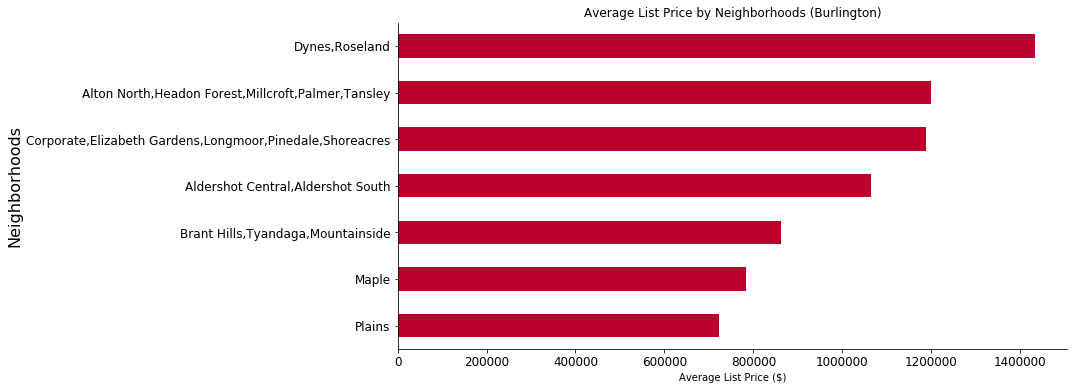

In [99]:
import matplotlib as mpl
import matplotlib.pyplot as plt

xcb = burlington_housing[['Neighborhood','Avg. List Price']].copy()
xcb.set_index('Neighborhood', inplace = True)
xcb.sort_values('Avg. List Price', ascending = True, inplace = True)

plt.figure(figsize=(12,6))
ax = xcb['Avg. List Price'].plot(kind="barh", color="#BC002D", fontsize=12)
ax.set_title("Average List Price by Neighborhoods (Burlington)")
ax.set_xlabel("Average List Price ($)")
ax.set_ylabel("Neighborhoods", fontsize = 16)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

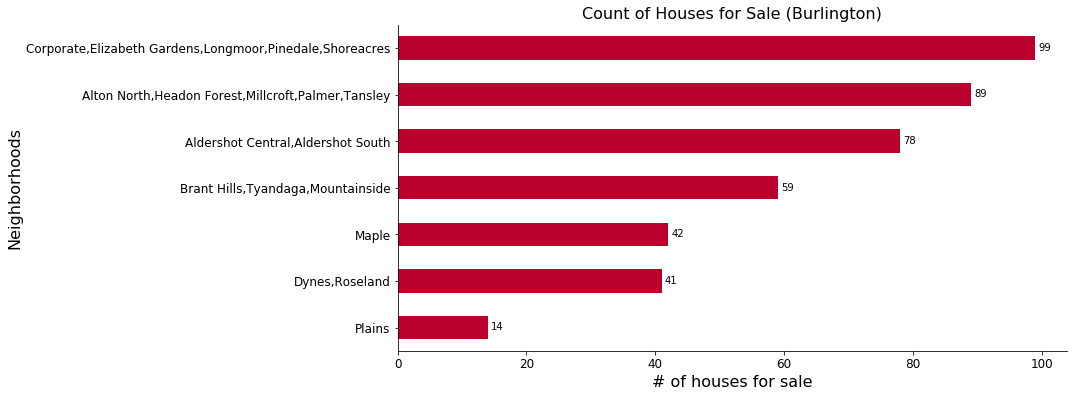

In [98]:
x0 = burlington_housing[['Neighborhood','Active Listings']].copy()
x0.set_index('Neighborhood', inplace = True)
x0.sort_values('Active Listings', ascending = True, inplace = True)

plt.figure(figsize=(12, 6))
ax = x0['Active Listings'].plot(kind="barh", color="#BC002D", fontsize=12)
ax.set_title("Count of Houses for Sale (Burlington)", fontsize=16)
ax.set_xlabel("# of houses for sale", fontsize=16)
ax.set_ylabel("Neighborhoods", fontsize=16)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for p in ax.patches:
    ax.annotate(str(p.get_width()), (p.get_width() + 0.5, p.get_y() + 0.2))

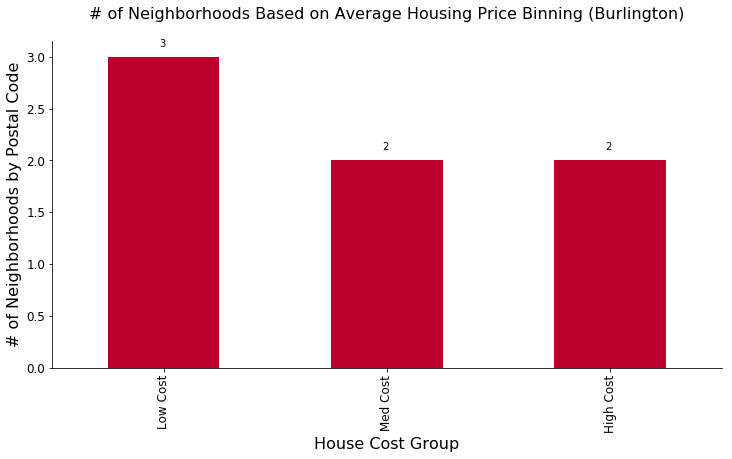

In [61]:
burlington_housing2 = burlington_housing.copy()
burlington_housing2.set_index('Neighborhood', inplace = True)
bins= np.linspace(min(burlington_housing2["Avg. List Price"]), max(burlington_housing2["Avg. List Price"]), 4)
group_names = ["Low Cost","Med Cost","High Cost"]
burlington_housing2["Avg. List Price-bin"] = pd.cut(burlington_housing2["Avg. List Price"], bins, labels=group_names, include_lowest=True)
burlington_housing2[["Avg. List Price", "Avg. List Price-bin"]].head(10)
burlington_housing2["Avg. List Price-bin"]

x1 = burlington_housing2.groupby('Avg. List Price-bin')['Active Listings'].count()

plt.figure(figsize=(12, 6))
ax = x1.plot(kind="bar", color="#BC002D", fontsize=12)
title = ax.set_title("# of Neighborhoods Based on Average Housing Price Binning (Burlington)", fontsize=16)
ax.set_xlabel("House Cost Group", fontsize=16)
ax.set_ylabel("# of Neighborhoods by Postal Code", fontsize=16)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
title.set_position([0.5,1.05])

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + 0.23, p.get_height() + 0.1))

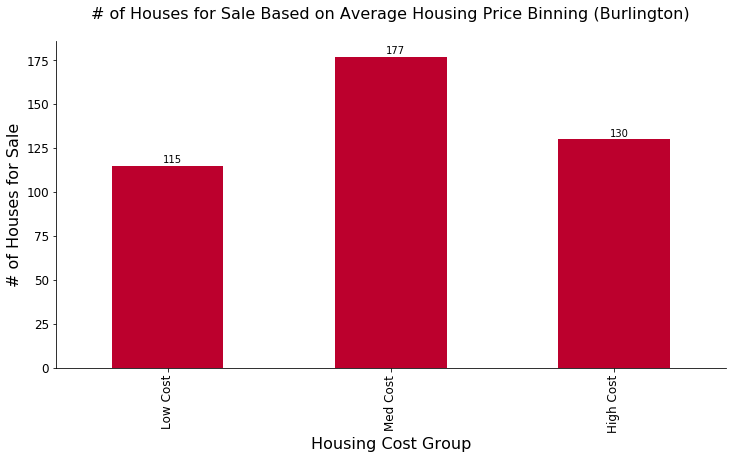

In [62]:
x3 = burlington_housing2.groupby('Avg. List Price-bin')['Active Listings'].sum()

plt.figure(figsize=(12, 6))
ax = x3.plot(kind="bar", color="#BC002D", fontsize=12)
title = ax.set_title("# of Houses for Sale Based on Average Housing Price Binning (Burlington)", fontsize=16)
ax.set_xlabel("Housing Cost Group", fontsize=16)
ax.set_ylabel("# of Houses for Sale", fontsize=16)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
title.set_position([0.5,1.05])

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + 0.23, p.get_height() + 1.5))

In [63]:
# Obtain min and max of each bin to see range in each bin
b_price_low = burlington_housing2.loc[burlington_housing2['Avg. List Price-bin'] == 'Low Cost']
b_price_lowL = min(b_price_low['Avg. List Price'])
b_price_lowH = max(b_price_low['Avg. List Price'])
b_price_low_range = b_price_lowH - b_price_lowL

b_price_med = burlington_housing2.loc[burlington_housing2['Avg. List Price-bin'] == 'Med Cost']
b_price_medL = min(b_price_med['Avg. List Price'])
b_price_medH = max(b_price_med['Avg. List Price'])
b_price_med_range = b_price_medH - b_price_medL

b_price_hi = burlington_housing2.loc[burlington_housing2['Avg. List Price-bin'] == 'High Cost']
b_price_hiL = min(b_price_hi['Avg. List Price'])
b_price_hiH = max(b_price_hi['Avg. List Price'])
b_price_hi_range = b_price_hiH - b_price_hiL

print('Burlington low cost minimum: ${:,.2f}'.format(b_price_lowL))
print('Burlington low cost maximum: ${:,.2f}'.format(b_price_lowH))
print('Burlington low cost range: ${:,.2f}'.format(b_price_low_range))
print("")
print('Burlington medium cost minimum: ${:,.2f}'.format(b_price_medL))
print('Burlington medium cost maximum: ${:,.2f}'.format(b_price_medH))
print('Burlington medium cost range: ${:,.2f}'.format(b_price_med_range))
print("")
print('Burlington high cost minimum: ${:,.2f}'.format(b_price_hiL))
print('Burlington high cost maximum: ${:,.2f}'.format(b_price_hiH))
print('Burlington high cost range: ${:,.2f}'.format(b_price_hi_range))

Burlington low cost minimum: $722,528.00
Burlington low cost maximum: $862,516.00
Burlington low cost range: $139,988.00

Burlington medium cost minimum: $1,064,370.00
Burlington medium cost maximum: $1,188,548.00
Burlington medium cost range: $124,178.00

Burlington high cost minimum: $1,199,763.20
Burlington high cost maximum: $1,434,010.50
Burlington high cost range: $234,247.30


In [64]:
pd.set_option('display.max_colwidth', -1)
print('Hamilton Neighborhoods dataframe size: ', hamilton_housing.shape)
hamilton_housing[['PostalCode','Neighborhood','Avg. List Price ($)','Active Listings']]

Hamilton Neighborhoods dataframe size:  (21, 7)


,PostalCode,Neighborhood,Avg. List Price ($),Active Listings
0,L8B,Waterdown,"$812,396.00",26
1,L8E,"Nashdale,Riverdale West,Lakely,Stoney Creek","$964,430.00",18
5,L8G,"Stoney Creek,Gershome,Gershome","$1,047,238.33",29
8,L8H,"McQuesten West,Parkview West,Hamilton Beach C,Normanhurst,Homeside,Crown Point West","$688,485.17",55
14,L8J,"Stoney Creek,Albion Falls","$782,926.50",10
16,L8K,"Gershome,Gershome,Eastmount,Bartonville,Glenview West,Rosedale,Red Hill,Corman,Vincent","$736,856.33",71
25,L8L,"Kernighan,Crown Point West,Stipley,Gibson,Landsdale,North End West,Beasley","$619,977.43",137
32,L8M,"Stipley,Gibson,Delta West,Blakeley,St. Clair","$637,186.20",71
37,L8N,"Stinson,Corktown","$614,637.00",45
39,L8P,"Durand,Kirkendall South","$1,050,649.00",34


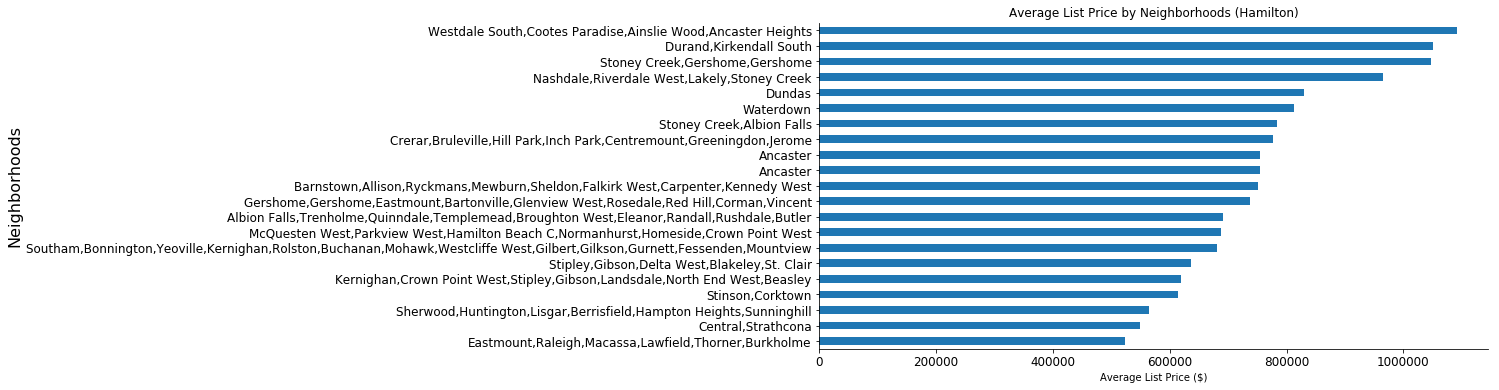

In [97]:
xch = hamilton_housing[['Neighborhood','Avg. List Price']].copy()
xch.set_index('Neighborhood', inplace = True)
xch.sort_values('Avg. List Price', ascending = True, inplace = True)

plt.figure(figsize=(12,6))
ax = xch['Avg. List Price'].plot(kind="barh", fontsize=12)
ax.set_title("Average List Price by Neighborhoods (Hamilton)")
ax.set_xlabel("Average List Price ($)")
ax.set_ylabel("Neighborhoods", fontsize = 16)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

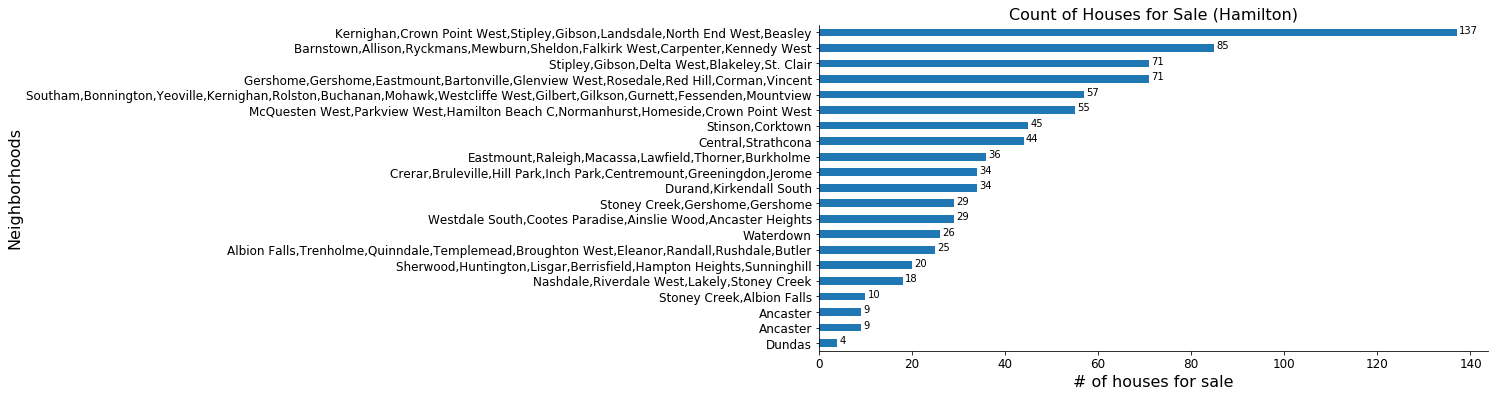

In [65]:
x3 = hamilton_housing[['Neighborhood','Active Listings']].copy()
x3.set_index('Neighborhood', inplace = True)
x3.sort_values('Active Listings', ascending = True, inplace = True)

plt.figure(figsize=(12, 6))
ax = x3['Active Listings'].plot(kind="barh", fontsize=12)
ax.set_title("Count of Houses for Sale (Hamilton)", fontsize=16)
ax.set_xlabel("# of houses for sale", fontsize=16)
ax.set_ylabel("Neighborhoods", fontsize=16)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for p in ax.patches:
    ax.annotate(str(p.get_width()), (p.get_width() + 0.5, p.get_y() + 0.2))

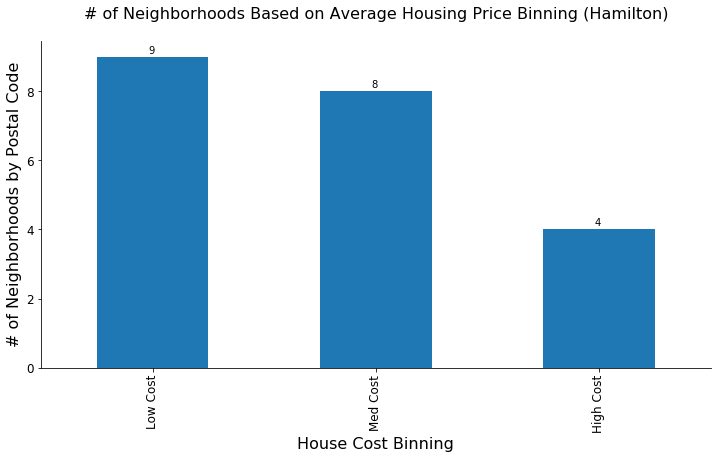

In [66]:
hamilton_housing2 = hamilton_housing.copy()
hamilton_housing2.set_index('Neighborhood', inplace = True)
bins= np.linspace(min(hamilton_housing2["Avg. List Price"]), max(hamilton_housing2["Avg. List Price"]), 4)
group_names2 = ["Low Cost","Med Cost","High Cost"]
hamilton_housing2["Avg. List Price-bin"] = pd.cut(hamilton_housing2["Avg. List Price"], bins, labels=group_names, include_lowest=True)

x4 = hamilton_housing2.groupby('Avg. List Price-bin')['Active Listings'].count()

plt.figure(figsize=(12, 6))
ax = x4.plot(kind="bar", fontsize=12)
title = ax.set_title("# of Neighborhoods Based on Average Housing Price Binning (Hamilton)", fontsize=16)
ax.set_xlabel("House Cost Binning", fontsize=16)
ax.set_ylabel("# of Neighborhoods by Postal Code", fontsize=16)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
title.set_position([0.5,1.05])

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + 0.23, p.get_height() + 0.1))

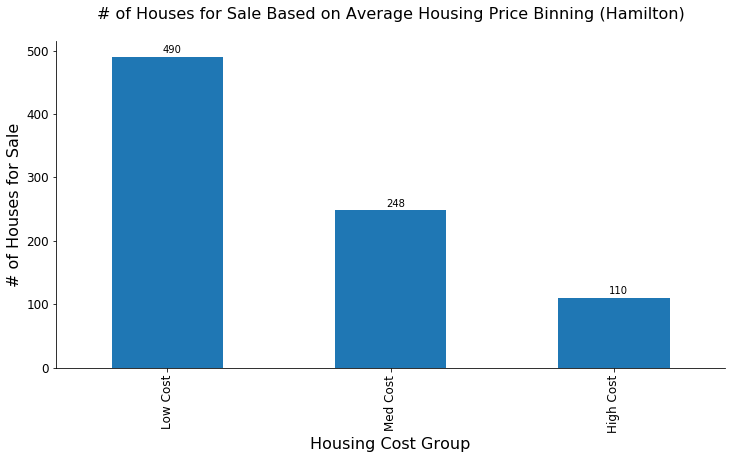

In [67]:
x5 = hamilton_housing2.groupby('Avg. List Price-bin')['Active Listings'].sum()

plt.figure(figsize=(12, 6))
ax = x5.plot(kind="bar", fontsize=12)
title = ax.set_title("# of Houses for Sale Based on Average Housing Price Binning (Hamilton)", fontsize=16)
ax.set_xlabel("Housing Cost Group", fontsize=16)
ax.set_ylabel("# of Houses for Sale", fontsize=16)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
title.set_position([0.5,1.05])

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + 0.23, p.get_height() + 6))

In [68]:
# Obtain min and max of each bin to see range in each bin
h_price_low = hamilton_housing2.loc[hamilton_housing2['Avg. List Price-bin'] == 'Low Cost']
h_price_lowL = min(h_price_low['Avg. List Price'])
h_price_lowH = max(h_price_low['Avg. List Price'])
h_price_low_range = h_price_lowH - h_price_lowL

h_price_med = hamilton_housing2.loc[hamilton_housing2['Avg. List Price-bin'] == 'Med Cost']
h_price_medL = min(h_price_med['Avg. List Price'])
h_price_medH = max(h_price_med['Avg. List Price'])
h_price_med_range = h_price_medH - h_price_medL

h_price_hi = hamilton_housing2.loc[hamilton_housing2['Avg. List Price-bin'] == 'High Cost']
h_price_hiL = min(h_price_hi['Avg. List Price'])
h_price_hiH = max(h_price_hi['Avg. List Price'])
h_price_hi_range = h_price_hiH - h_price_hiL

print('Hamilton low cost minimum: ${:,.2f}'.format(h_price_lowL))
print('Hamilton low cost maximum: ${:,.2f}'.format(h_price_lowH))
print('Hamilton low cost range: ${:,.2f}'.format(h_price_low_range))
print("")
print('Hamilton medium cost minimum: ${:,.2f}'.format(h_price_medL))
print('Hamilton medium cost maximum: ${:,.2f}'.format(h_price_medH))
print('Hamilton medium cost range: ${:,.2f}'.format(h_price_med_range))
print("")
print('Hamilton high cost minimum: ${:,.2f}'.format(h_price_hiL))
print('Hamilton high cost maximum: ${:,.2f}'.format(h_price_hiH))
print('Hamilton high cost range: ${:,.2f}'.format(h_price_hi_range))

Hamilton low cost minimum: $523,616.50
Hamilton low cost maximum: $690,796.11
Hamilton low cost range: $167,179.61

Hamilton medium cost minimum: $736,856.33
Hamilton medium cost maximum: $829,700.00
Hamilton medium cost range: $92,843.67

Hamilton high cost minimum: $964,430.00
Hamilton high cost maximum: $1,090,791.75
Hamilton high cost range: $126,361.75


<Figure size 864x432 with 0 Axes>

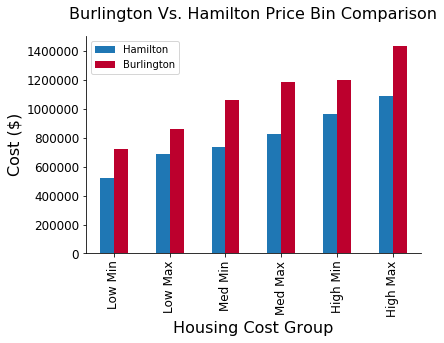

In [69]:
import matplotlib as mpl
import matplotlib.pyplot as plt

data = {'city_info':['Low Min','Low Max','Med Min','Med Max','High Min','High Max'],
       'Hamilton':[523616,690796,736856,829700,964430,1090791],
       'Burlington':[722528,862516,1064370,1188548,1199763,1434010]}

cost_comparison = pd.DataFrame(data)

x6 = cost_comparison.set_index('city_info').copy()

plt.figure(figsize=(12, 6))
ax = x6.plot(kind="bar", fontsize=12, color = ['#1F77B4','#BC002D'])
title = ax.set_title("Burlington Vs. Hamilton Price Bin Comparison", fontsize=16)
ax.set_xlabel("Housing Cost Group", fontsize=16)
ax.set_ylabel("Cost ($)", fontsize=16)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
title.set_position([0.5,1.05])


From the dataframes for both Burlington and Hamilton above we are able to answer the first question of **What are the different neighborhoods in each city?**. We were also able to make some addition observations as noted below:

* Both cities have postal codes that contain several neighborhoods
* Hamilton has significantly more neighborhoods than Burlington
    * Only 7 postal codes in Burlington compared to Hamiltons 21 postal codes
    
Knowing the different neighborhood names with their associated postal codes is good and all, but it doesn't help us in terms of picturing where exactly the neighborhoods are.  Next we will visualize where the neighborhoods are in both cities on a map based on their postal codes.

In [70]:
address = 'Burlington, ON'

geolocator = Nominatim(user_agent="burlington_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Burlington are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Burlington are 43.3248924, -79.7966835.


In [71]:
# Visualize Burlington neighborhoods
map_burlington = folium.Map(location=[latitude, longitude], zoom_start=12)

for lat, lng, neighborhood, price, active in zip(burlington_housing['Latitude'], burlington_housing['Longitude'], burlington_housing['Neighborhood'],
                                 burlington_housing['Avg. List Price ($)'], burlington_housing['Active Listings']):
    label = 'Neighborhoods: {} \n Avg. List Price: {} \n Active Listings: {}'.format(neighborhood, price, active)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_burlington)  

map_burlington

In [72]:
# Visualize Hamilton neighborhoods
map_hamilton = folium.Map(location=[latitude2, longitude2], zoom_start=12)

for lat, lng, neighborhood, price, active in zip(hamilton_housing['Latitude'], hamilton_housing['Longitude'], hamilton_housing['Neighborhood'],
                                                hamilton_housing['Avg. List Price ($)'], hamilton_housing['Active Listings']):
    label = 'Neighborhoods: {} \n Avg. List Price: {} \n Active Listings: {}'.format(neighborhood, price, active)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_hamilton)  

map_hamilton

### 5.3 Clustering

We will start on clustering the Burlington neighborhoods based on active listings and average house prices.

In [73]:
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors

In [74]:
# set number of clusters
kclusters = 4

burlington_grouped_clustering = burlington_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(burlington_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([3, 2, 0, 1, 0], dtype=int32)

#### Create a new dataframe that includes cluster and 10 venues in Burlington neighborhoods

In [75]:
# add clustering labels
burlington_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

burlington_data2 = burlington_housing_clean[['Neighborhood','Longitude','Latitude']].copy()
burlington_merged = burlington_data2

# merge burlington_data_2 with burlington_venues_sorted to add latitude/longitude for each neighborhood
burlington_merged = burlington_merged.merge(burlington_venues_sorted.set_index('Neighborhood'), on = 'Neighborhood')

print(burlington_merged.shape)
burlington_merged.head()

(5, 14)


,Neighborhood,Longitude,Latitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Corporate,Elizabeth Gardens,Longmoor,Pinedale,Shoreacres",-79.767496,43.384449,2,Department Store,Athletics & Sports,Skating Rink,Gym / Fitness Center,Dessert Shop,Ice Cream Shop,Hotel,Hardware Store,Gas Station,Furniture / Home Store
1,"Dynes,Roseland",-79.783412,43.351052,0,Furniture / Home Store,Sandwich Place,Liquor Store,Dessert Shop,Thrift / Vintage Store,Kids Store,Ice Cream Shop,Fast Food Restaurant,Discount Store,Convenience Store
2,Plains,-79.804560,43.353290,0,Restaurant,Pub,Gym / Fitness Center,Gas Station,Mediterranean Restaurant,Furniture / Home Store,Parking,Pet Store,Pizza Place,Hotel
3,Maple,-79.810205,43.317173,1,Italian Restaurant,Brewery,Clothing Store,Discount Store,Ice Cream Shop,Hotel,Hardware Store,Gym / Fitness Center,Gas Station,Furniture / Home Store
4,"Aldershot Central,Aldershot South",-79.855320,43.313290,3,Train Station,Coffee Shop,Platform,Road,Ice Cream Shop,Brewery,Discount Store,Hotel,Hardware Store,Gym / Fitness Center


#### Visualize Burlington Neighborhood Clusters Based on Top Venues

In [76]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(burlington_merged['Latitude'], burlington_merged['Longitude'], burlington_merged['Neighborhood'], burlington_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='black',
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Examine Clusters

Now we can examine each individual cluster and determine what type of common venues distinguish the clusters from one another. 

#### Cluster 0 Analysis

In [77]:
burlington_merged.loc[burlington_merged['Cluster Labels'] == 0, burlington_merged.columns[[0] + list(range(4, burlington_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,"Dynes,Roseland",Furniture / Home Store,Sandwich Place,Liquor Store,Dessert Shop,Thrift / Vintage Store,Kids Store,Ice Cream Shop,Fast Food Restaurant,Discount Store,Convenience Store
2,Plains,Restaurant,Pub,Gym / Fitness Center,Gas Station,Mediterranean Restaurant,Furniture / Home Store,Parking,Pet Store,Pizza Place,Hotel


Cluster 0 has a heavy mix of restaurants and stores.

#### Cluster 1 Analysis

In [78]:
burlington_merged.loc[burlington_merged['Cluster Labels'] == 1, burlington_merged.columns[[0] + list(range(4, burlington_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Maple,Italian Restaurant,Brewery,Clothing Store,Discount Store,Ice Cream Shop,Hotel,Hardware Store,Gym / Fitness Center,Gas Station,Furniture / Home Store


Cluster 1 has a mix of fitness, resturants, stores, but is the only area with a brewery.

#### Cluster 2 Analysis

In [79]:
burlington_merged.loc[burlington_merged['Cluster Labels'] == 2, burlington_merged.columns[[0] + list(range(4, burlington_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Corporate,Elizabeth Gardens,Longmoor,Pinedale,Shoreacres",Department Store,Athletics & Sports,Skating Rink,Gym / Fitness Center,Dessert Shop,Ice Cream Shop,Hotel,Hardware Store,Gas Station,Furniture / Home Store


Cluster 2 is more fitness heavy with the venues surrounding the neighborhoods.

#### Cluster 3 Analysis

In [80]:
burlington_merged.loc[burlington_merged['Cluster Labels'] == 3, burlington_merged.columns[[0] + list(range(4, burlington_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,"Aldershot Central,Aldershot South",Train Station,Coffee Shop,Platform,Road,Ice Cream Shop,Brewery,Discount Store,Hotel,Hardware Store,Gym / Fitness Center


Cluster 3 looks to be more of a commuter area as the top common venues are related to the Go Train station and the roads.

#### Hamilton Clustering

In [81]:
# set number of clusters
kclusters = 3

hamilton_grouped_clustering = hamilton_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(hamilton_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([0, 2, 2, 1, 2], dtype=int32)

#### Create a new dataframe that includes cluster and 10 venues in Hamilton neighborhoods

In [82]:
# add clustering labels
h_neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

hamilton_data2 = hamilton_venues.rename(columns = {'Neighborhood Latitude': 'Latitude', 'Neighborhood Longitude':'Longitude'})
hamilton_data2.drop_duplicates(subset = 'Neighborhood', keep = 'first', inplace = True)
hamilton_merged = hamilton_data2[['Neighborhood','Latitude','Longitude']].copy()

# merge hamilton_data2 with hamilton_venues_sorted to add latitude/longitude for each neighborhood
hamilton_merged = hamilton_merged.merge(h_neighborhoods_venues_sorted, on = 'Neighborhood')

hamilton_merged.dropna(axis = 0, inplace = True)

print(hamilton_merged.shape)
hamilton_merged

(5, 14)


,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Central,Strathcona",43.270028,-79.875724,1,Beach,Park,Wings Joint,Department Store,Gas Station,Furniture / Home Store,Food Truck,Flower Shop,Fish & Chips Shop,Fast Food Restaurant
1,"Albion Falls,Trenholme,Quinndale,Templemead,Broughton West,Eleanor,Randall,Rushdale,Butler",43.194916,-79.847137,0,Gas Station,Fast Food Restaurant,Sandwich Place,Discount Store,Pizza Place,Wings Joint,Construction & Landscaping,Furniture / Home Store,Food Truck,Flower Shop
2,"Crerar,Bruleville,Hill Park,Inch Park,Centremount,Greeningdon,Jerome",43.226064,-79.870944,2,Coffee Shop,Fast Food Restaurant,Motorcycle Shop,Office,Pizza Place,Pharmacy,Wings Joint,Department Store,Furniture / Home Store,Food Truck
3,"Barnstown,Allison,Ryckmans,Mewburn,Sheldon,Falkirk West,Carpenter,Kennedy West",43.202345,-79.898150,2,Restaurant,Coffee Shop,Fast Food Restaurant,Wings Joint,Pharmacy,Kids Store,Portuguese Restaurant,Sandwich Place,Juice Bar,Shopping Mall
4,Ancaster,43.226360,-79.942680,2,Fast Food Restaurant,Pharmacy,Sporting Goods Shop,Shopping Mall,Sandwich Place,Department Store,Wings Joint,Vietnamese Restaurant,Gym,Grocery Store


#### Visualize Hamilton Neighborhoods Clustering Based on Top Venues

In [83]:
# create map
h_map_clusters = folium.Map(location=[latitude2, longitude2], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(hamilton_merged['Latitude'], hamilton_merged['Longitude'], hamilton_merged['Neighborhood'], hamilton_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='black',
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(h_map_clusters)
       
h_map_clusters

#### Cluster 0 Analysis

In [84]:
hamilton_merged.loc[hamilton_merged['Cluster Labels'] == 0, hamilton_merged.columns[[0] + list(range(4, hamilton_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,"Albion Falls,Trenholme,Quinndale,Templemead,Broughton West,Eleanor,Randall,Rushdale,Butler",Gas Station,Fast Food Restaurant,Sandwich Place,Discount Store,Pizza Place,Wings Joint,Construction & Landscaping,Furniture / Home Store,Food Truck,Flower Shop


Cluster 0 has mostly food takeout locations as its top venues.

#### Cluster 1 Analysis

In [85]:
hamilton_merged.loc[hamilton_merged['Cluster Labels'] == 1, hamilton_merged.columns[[0] + list(range(4, hamilton_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Central,Strathcona",Beach,Park,Wings Joint,Department Store,Gas Station,Furniture / Home Store,Food Truck,Flower Shop,Fish & Chips Shop,Fast Food Restaurant


Cluster 1 is the only cluster that has a beach and park in its top 10 venues.

#### Cluster 2 Analysis

In [86]:
hamilton_merged.loc[hamilton_merged['Cluster Labels'] == 2, hamilton_merged.columns[[0] + list(range(4, hamilton_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,"Crerar,Bruleville,Hill Park,Inch Park,Centremount,Greeningdon,Jerome",Coffee Shop,Fast Food Restaurant,Motorcycle Shop,Office,Pizza Place,Pharmacy,Wings Joint,Department Store,Furniture / Home Store,Food Truck
3,"Barnstown,Allison,Ryckmans,Mewburn,Sheldon,Falkirk West,Carpenter,Kennedy West",Restaurant,Coffee Shop,Fast Food Restaurant,Wings Joint,Pharmacy,Kids Store,Portuguese Restaurant,Sandwich Place,Juice Bar,Shopping Mall
4,Ancaster,Fast Food Restaurant,Pharmacy,Sporting Goods Shop,Shopping Mall,Sandwich Place,Department Store,Wings Joint,Vietnamese Restaurant,Gym,Grocery Store


Cluster 2 has mostly coffee shops and fast food restaurants as its top venues.

# 6. Conclusion

From the completed analysis we were able to find some interesting information between the neighborhoods in Hamilton and Burlington when it comes to searching for a house to buy.  Below is a summary of our findings:

* Hamilton has significantly more neighborhoods in comparison to Burlington
* The cost of housing in Burlington is more expensive than Hamilton when binned into 3 categories (Low, medium, and high cost)
    * Burlington Low Cost - \\$722,528 to \\$862,516
    * Hamilton Low Cost - \\$523,616 to \\$690,796
* The number of active listings in Burlington and Hamilton based on the binned categories are very different
    * Burlington - Number of active houses for sale is the highest in the medium cost range and lowest in the low cost range
    * Hamilton - Number of active houses for sale is the highest in the low cost range and lowest in the high cost range
* We found that the amount of foursquare data was smaller than expected as there were very few neighborhoods with venues that were being visited
    * This may be attributed to the COVID shutdown that has been ongoing from the past several months starting back in March 2020
    
From looking at the clustered data for both Burlington and Hamilton neighborhoods we are able to see that Hamilton neighborhoods are much more food centric in regards to top venues whereas Burlington is much more diverse.  For Burlington we were also able to identify an area as a *commuter* area as the top 3 venues were related to transit.

In my situation there is not a neighborhood that perfectly fits with what I am looking for which are: affordable neighborhood, fitness ameneties and restaurants/coffess shops within walking distance.  With this information I will have to rank what I believe would be priority for myself when deciding where to purchase a house.

Good luck to all of those that are also looking to take the next step to buy a house!    